# YouTube Like Prediction - Part 2

In this notebook, we continue the analysis by leveraging the preprocessed data from Part 1.

## Step 1: Load the Preprocessed Data and review Part1 Error analysis
The preprocessed data from Part 1 was saved in a CSV file named `clean_data.csv`. We will load this file using `pandas` and verify its content.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file
path = "./clean_data.csv"
df = pd.read_csv(path)

# Display the first few rows to confirm the data
df.head()

,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,days_to_trend,category_Entertainment,category_Howto & Style,category_Music,...,trending_date_day_22,trending_date_day_23,trending_date_day_24,trending_date_day_25,trending_date_day_26,trending_date_day_27,trending_date_day_28,trending_date_day_29,trending_date_day_30,trending_date_day_31
0,748374,57527,2966,15954,False,False,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2418783,97185,6146,12703,False,False,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,343168,10172,666,2146,False,False,1,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2095731,132235,1989,17518,False,False,2,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,119180,9763,511,1434,False,False,1,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["likes"])
y = df["likes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4616, 100), (1154, 100), (4616,), (1154,))

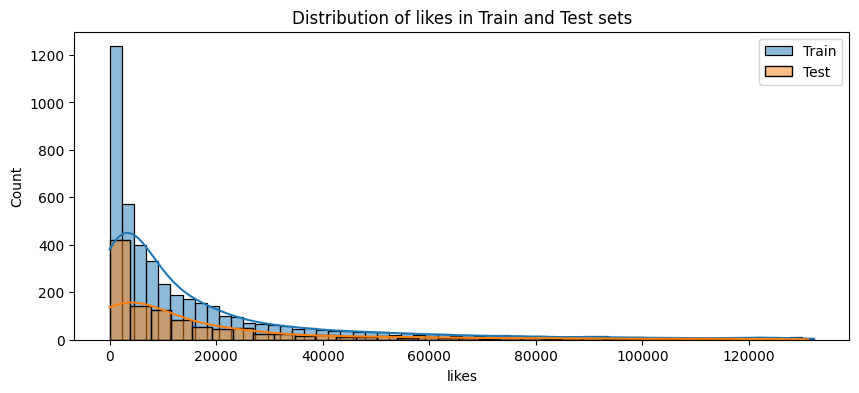

In [4]:
# Let's see that the distribution of the target variable is similar in both the train and test sets
plt.figure(figsize=(10, 4))
sns.histplot(y_train, kde=True, label="Train")
sns.histplot(y_test, kde=True, label="Test")
plt.title("Distribution of likes in Train and Test sets")
plt.legend()
plt.show()

In [5]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


In [6]:
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R2 score on train set: {r2_train:.2f}")
print(f"R2 score on test set: {r2_test:.2f}")

print(
    "Mean Absolute Perc Error (Σ(|y - pred|/y)/n):",
    "{:,.3f}".format(mean_absolute_percentage_error(y_test.values, y_test_pred)),
)
print(
    "Mean Absolute Error (Σ|y - pred|/n):",
    "{:,.0f}".format(mean_absolute_error(y_test, y_test_pred)),
)
print(
    "Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)):",
    "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_test_pred))),
)

R2 score on train set: 1.00
R2 score on test set: 0.77
Mean Absolute Perc Error (Σ(|y - pred|/y)/n): 136,538,062,688,707,312.000
Mean Absolute Error (Σ|y - pred|/n): 6,651
Root Mean Squared Error (sqrt(Σ(y - pred)^2/n)): 12,283


We check maximal error's original records and found two main resons for the high error:
- the `likes` is 0!
- the `rating_disabled` is 1

It means that the model is not able to predict the `likes` feature for videos that have no likes, or have the rating disabled.

In [7]:
df.loc[df["ratings_disabled"] == True, "likes"].value_counts()


likes
0    23
Name: count, dtype: int64

We remove 'ratings_disabled' = True rows correlating with 'likes' = 0

In [8]:
rows_to_drop = df.loc[df["ratings_disabled"] == True].index

df = df.drop(index=rows_to_drop, errors="ignore")
df = df.drop(columns=["ratings_disabled"])

In [9]:
# Check for rows where likes = 0
zero_likes = df[df['likes'] == 0]
print(f"Number of rows with likes = 0: {len(zero_likes)}")

Number of rows with likes = 0: 1


## Step 2: Improving Model Performance

In this section, Based on the observed errors, we will:
1. Identify potential causes of errors in the model's predictions.
2.  address weaknesses in the initial baseline model.
3. Perform techniques to improve the model.


#### A reminder from previous part 1

We performed the following as part of feature engineering process and in the current notebook we are working on the preprocessed data.
1. `video_id` was not unique for each row, hence we droped duplicated video_ids and kept the first trending date(which was the different value in the duplicated raws).
2. `likes` we cut the top 5% duo to tailed distribution.
3. `category_id` We load the categories names and merge them with the data instead of `category_id` since it is a categorical feature.
We saw there were some categories with very few videos, we aggregated them into a single category: `Other`
4. `video_error_or_removed` we removed this feature because there was only 3 videos with `video_error_or_removed` set to 1, with no significant difference in the `likes` feature.  
5. time features: We have 2 time features: `publish_time` and `trending_date`.  
and we create the following features:
- `publish_hour`
- `publish_day`
- `publish_dayofweek`
- `trending_day`
- `days_to_trend`
6. textual features: We have 3 textual features: `title` and `tags`, and `description`.  
we saw they do not have any effect on `likes` hence we droped them.



### Feature engineering

#### Target Variable Distribution
We begin by visualizing the distribution of `likes` to check for skewness, imbalance, or outliers.

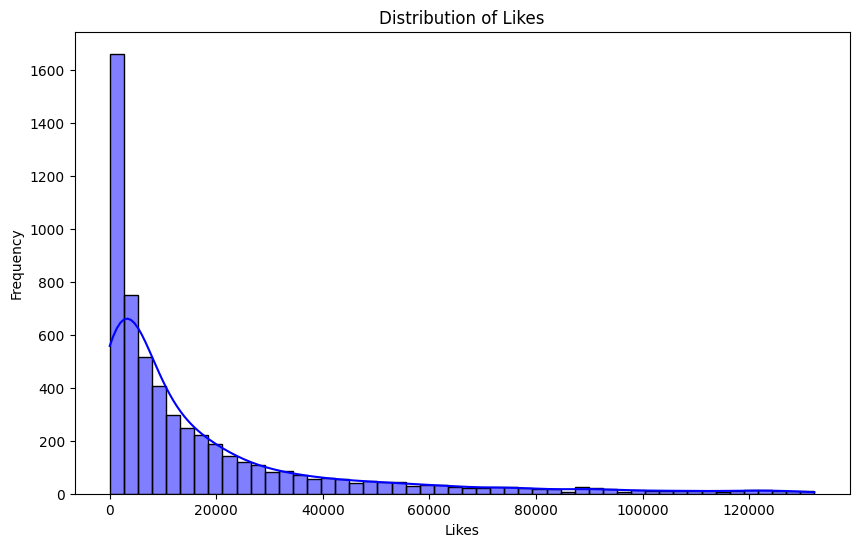

In [10]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['likes'], kde=True, bins=50, color='blue')
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Frequency')
plt.show()

##### Observations:
1. The distribution of likes is heavily skewed to the right, with a large number of videos having very low likes (near 0) and a few videos having extremely high likes (outliers).
2. The majority of the data points cluster in the low-like range (0–10,000), while very few points fall into the high-like range (greater than 50,000).
3. The skewness and presence of extreme outliers may lead to bias in model predictions, as the model may struggle to generalize well to these extreme cases.


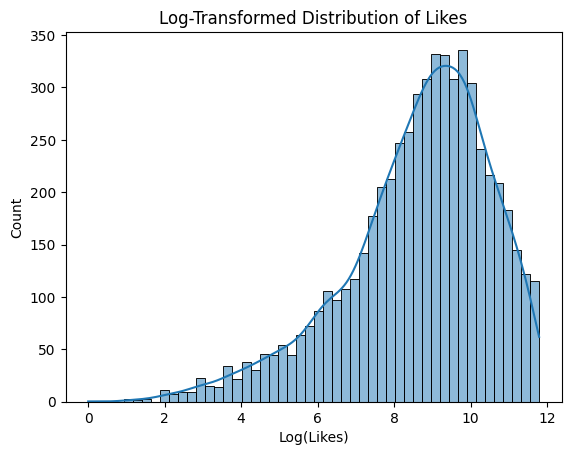

In [11]:
# Log transformation visualization
sns.histplot(np.log1p(df['likes']), kde=True, bins=50)
plt.title("Log-Transformed Distribution of Likes")
plt.xlabel("Log(Likes)")
plt.show()

target variable (likes) is heavily skewed- extreme values (outliers). Hence, in order to reduced skewness we will performe log transformation

In [12]:
# Apply log transformation
# Reduces skewness and stabilizes variance.
df['likes_log'] = np.log1p(df['likes'])
df = df.drop(columns=['likes'])

We will further Investigate Features Impacting the model Performance

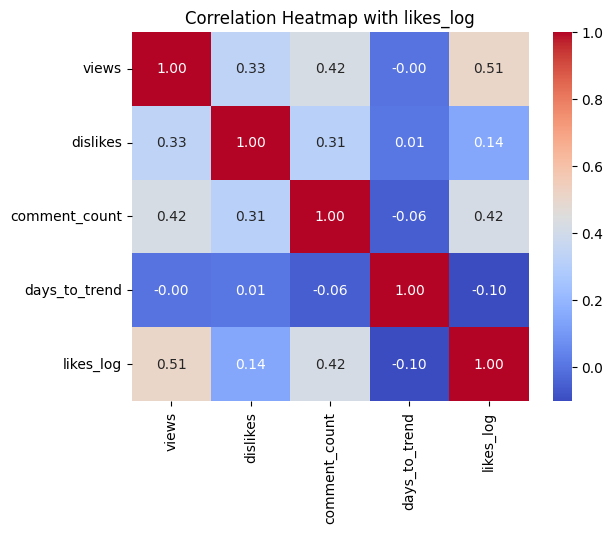

In [13]:
# Correlation heatmap for natural numerical features
numerical_features = ['views', 'dislikes', 'comment_count', 'days_to_trend']
sns.heatmap(df[numerical_features + ['likes_log']].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap with likes_log")
plt.show()

Features with very low correlation may introduce noise and increase model complexity. 
Hence, we will evaluate the impact of removing days_to_trend or dislikes

In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = df['likes_log']  # Use transformed target variable
X_all = df.drop(columns=['likes_log'])  # Case 1: All features
X_no_days = df.drop(columns=['likes_log', 'days_to_trend'])  # Case 2: Remove 'days_to_trend'
X_no_dislikes = df.drop(columns=['likes_log', 'dislikes'])  # Case 3: Remove 'dislikes'
X_no_both = df.drop(columns=['likes_log', 'days_to_trend', 'dislikes'])  # Case 4: Remove both

# Define a function to train and evaluate the model
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Evaluate each case
print("RMSE with all features:", train_and_evaluate(X_all, y))
print("RMSE without 'days_to_trend':", train_and_evaluate(X_no_days, y))
print("RMSE without 'dislikes':", train_and_evaluate(X_no_dislikes, y))
print("RMSE without both 'days_to_trend' and 'dislikes':", train_and_evaluate(X_no_both, y))


RMSE with all features: 0.6419197916309686
RMSE without 'days_to_trend': 0.6537121405895983
RMSE without 'dislikes': 0.6744042623807576
RMSE without both 'days_to_trend' and 'dislikes': 0.6765491311957785


Removing either `days_to_trend` or `dislikes` leads to worse model performance, indicating that both contribute valuable information.
The results suggest that these features might have non-linear effects or interactions with other features, which linear correlation cannot capture.

Low correlation of `dislikes` (0.14) and `days_to_trend` (-0.10) suggests these features might not have strong linear relationships with the target but may still capture valuable non-linear effects.

A log transformation might improve their usability by stabilizing their variance.
However, we must verify the distributions before deciding.

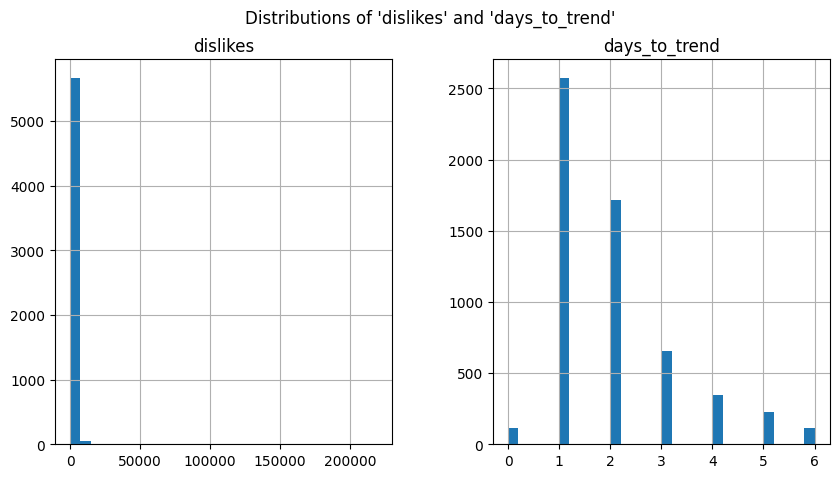

In [15]:
# Distribution of 'dislikes' and 'days_to_trend'
# Rationale: Check for skewness to justify log transformation.
df[['dislikes', 'days_to_trend']].hist(bins=30, figsize=(10, 5))
plt.suptitle("Distributions of 'dislikes' and 'days_to_trend'")
plt.show()

### `dislikes`

In [16]:
print(df['dislikes'].value_counts())

dislikes
0       40
4       38
1       37
5       36
13      33
        ..
1137     1
2781     1
6491     1
1015     1
3303     1
Name: count, Length: 1698, dtype: int64


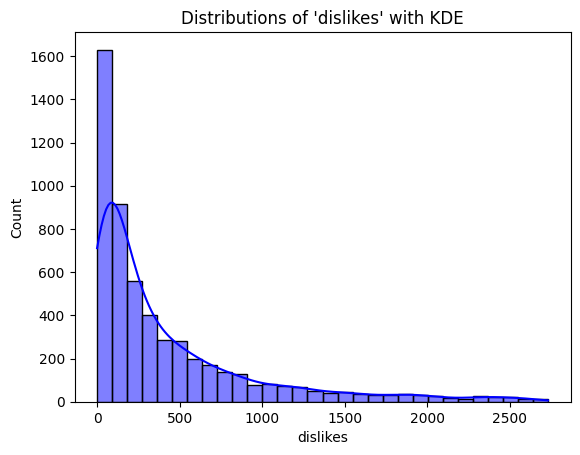

In [17]:
# The tail is very long, let's cut the top 5% and see the histogram again
percentile_95_dislikes = df["dislikes"].quantile(0.95)
df_filtered = df[(df["dislikes"] <= percentile_95_dislikes)]


sns.histplot(df_filtered['dislikes'], kde=True, bins=30, color='blue')
plt.title("Distributions of 'dislikes' with KDE")
plt.show()

In [18]:
df = df_filtered

The feature is highly skewed.
This indicates that most entries have zero and low number of dislikes, and very few have a significant number of dislikes.

A log transformation can compress large values while spreading out smaller values, making the distribution more normal-like.
Since 0 dislikes dominate, a log(x + 1) transformation is preferred to handle zeros

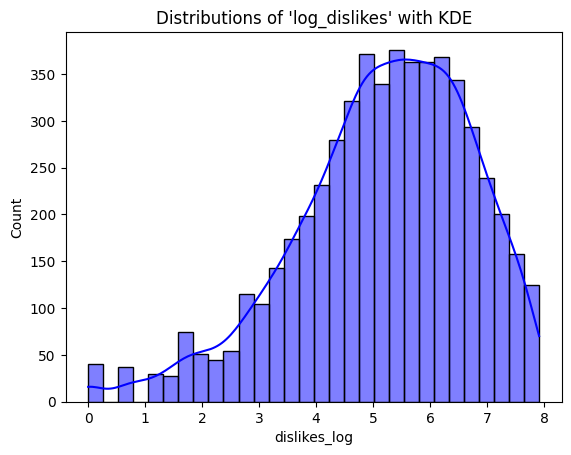

In [19]:
import seaborn as sns

#Log Transform Skewed Feature
df['dislikes_log'] = np.log1p(df['dislikes'])

sns.histplot(df['dislikes_log'], kde=True, bins=30, color='blue')
plt.title("Distributions of 'log_dislikes' with KDE")
plt.show()

Check the correlation between log_dislikes and your target variable (likes) to confirm the transformation preserves meaningful relationships:

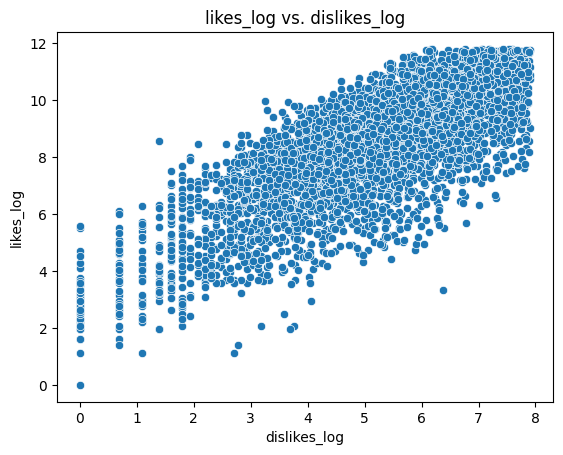

              dislikes_log  likes_log
dislikes_log      1.000000   0.780286
likes_log         0.780286   1.000000


In [20]:
sns.scatterplot(x='dislikes_log', y='likes_log', data=df)
plt.title("likes_log vs. dislikes_log")
plt.show()

correlation = df[['dislikes_log', 'likes_log']].corr()
print(correlation)

Significant increase in correlation from 0.14 to 0.7 after applying the log transformation 
We can now drop the original dislikes feature.

In [21]:
df.drop('dislikes', axis=1, inplace=True)

### `days_to_trend`

The feature `days_to_trend` is ordinal (i.e., values have a meaningful order), but the intervals between the values are not necessarily consistent. Therefore, we should treat this feature as ordinal and preserve its inherent order.

In [22]:
# Check correlation with likes_log
correlation = df[['days_to_trend', 'likes_log']].corr()
print(correlation)

               days_to_trend  likes_log
days_to_trend       1.000000  -0.100544
likes_log          -0.100544   1.000000


A correlation of -0.10 suggests there is almost no linear relationship between days_to_trend and likes_log.

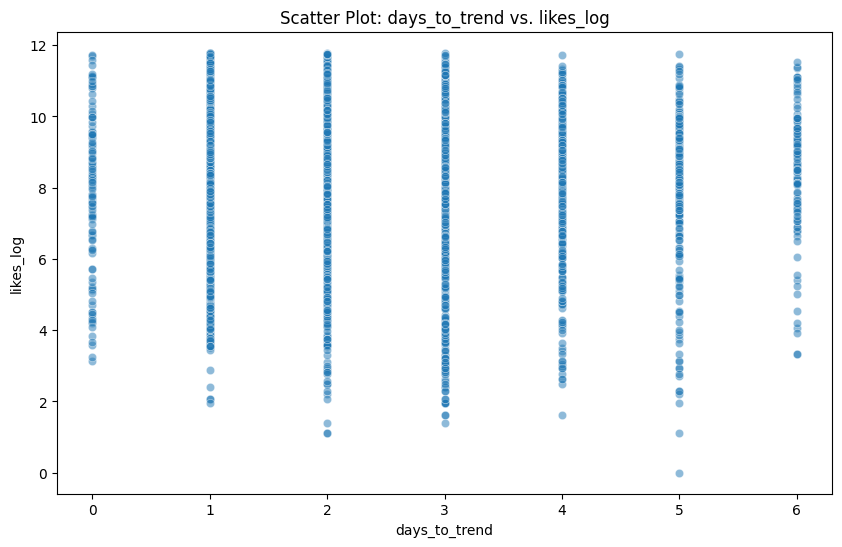

In [23]:
# Visualize days_to_trend vs. likes_log using scatterplot to check for patterns.
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_to_trend', y='likes_log', data=df, alpha=0.5)
plt.title('Scatter Plot: days_to_trend vs. likes_log')
plt.xlabel('days_to_trend')
plt.ylabel('likes_log')
plt.show()

The values of likes_log are spread widely across all values of days_to_trend.
Categories 1, 2, and 3 dominate the data, as expected from the distribution provided earlier.
Categories 0, 4, 5, and 6 are sparsely populated and don’t show any distinct patterns.

Hence, We will Combine Rare Categories: Group 0, 4, 5, and 6 into a single "Other" category and apply one-hot encoding. This avoids overfitting due to sparsity and simplifies the feature representation.

In [24]:
# Combine rare categories into 'Other'
df['days_to_trend_combined'] = df['days_to_trend'].replace({0: 'Other', 4: 'Other', 5: 'Other', 6: 'Other'})
# Apply one-hot encoding
df = pd.get_dummies(df, columns=['days_to_trend_combined'], drop_first=True)

In [25]:
# Define feature sets
y = df['likes_log']  # Use transformed target variable
X_all = df.drop(columns=['likes_log'])  # Case A: All features (including one-hot-encoded 'days_to_trend_combined')
X_no_days_combined = df.drop(columns=['likes_log', 'days_to_trend_combined_2', 
                                       'days_to_trend_combined_3', 'days_to_trend_combined_Other'])  # Case B: Remove transformed one-hot features
X_no_days = df.drop(columns=['likes_log', 'days_to_trend', 'days_to_trend_combined_2', 
                              'days_to_trend_combined_3', 'days_to_trend_combined_Other'])  # Case C: Remove both original and transformed
X_no_original_days = df.drop(columns=['likes_log', 'days_to_trend'])


# Define a function to train and evaluate the model
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Evaluate each case
print("RMSE with one-hot-encoded 'days_to_trend_combined':", train_and_evaluate(X_all, y))
print("RMSE without transformed 'days_to_trend_combined':", train_and_evaluate(X_no_days_combined, y))
print("RMSE without both 'days_to_trend' and transformed version:", train_and_evaluate(X_no_days, y))
print("RMSE with transformed 'days_to_trend_combined':", train_and_evaluate(X_no_original_days, y))

RMSE with one-hot-encoded 'days_to_trend_combined': 0.6360743189184935
RMSE without transformed 'days_to_trend_combined': 0.6397883821576876
RMSE without both 'days_to_trend' and transformed version: 0.6484129787604269
RMSE with transformed 'days_to_trend_combined': 0.6411655804396452


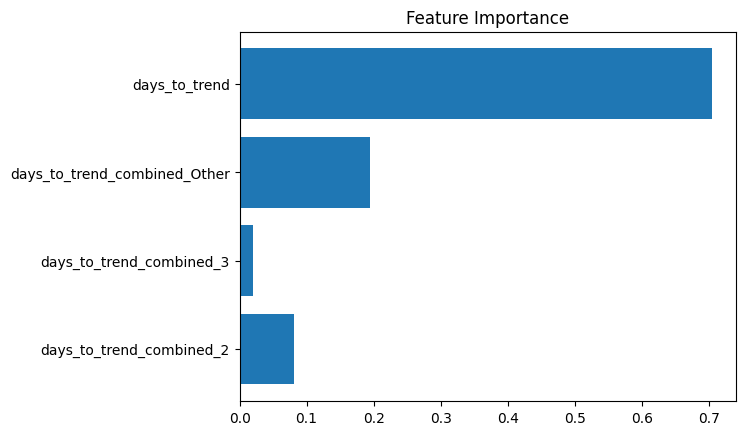

In [26]:
# Define the selected features
selected_features = [
    'days_to_trend_combined_2', 'days_to_trend_combined_3', 'days_to_trend_combined_Other', 'days_to_trend'
    # Add more features here as needed
]

# Filter the dataset to include only the selected features
X_selected = X_all[selected_features]

# Train the model on the selected feature set
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Plot feature importance for the selected features
import matplotlib.pyplot as plt
importance = model.feature_importances_
columns = X_selected.columns  # Features include only the selected ones
plt.barh(columns, importance)
plt.title("Feature Importance")
plt.show()


Since 'days_to_trend' contributes to the model’s performance and removing it (either in original or transformed form) leads to a higher RMSE, it’s clear that this feature should remain in the model.
In addition, it is not necessary to keep both versions of 'days_to_trend' (transformed and original) in the model, as this could lead to redundancy.

In [27]:
df = df.drop(columns=['days_to_trend_combined_2', 'days_to_trend_combined_3', 'days_to_trend_combined_Other'])


check feature importance values to further investigate features based on Importance:

In [28]:
# Train the model on the full dataset
X_all = df.drop(columns=['likes_log'])
y = df['likes_log']

# Train and evaluate function
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return model, rmse

# Train the model and get feature importance
model, rmse_all = train_and_evaluate(X_all, y)
print(f"Base RMSE: {rmse_all}")

# Get feature importances
importances = model.feature_importances_
feature_names = X_all.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Print the most important features
print("Most Important Features:")
print(feature_importance_df.head(10))  # Show top 10 features by importance


Base RMSE: 0.6397883821576876
Most Important Features:
                     feature  importance
1              comment_count    0.217865
7   category_News & Politics    0.094794
0                      views    0.077563
2          comments_disabled    0.057261
6             category_Music    0.024312
48       publish_time_hour_4    0.015591
5     category_Howto & Style    0.014623
4     category_Entertainment    0.013611
8             category_Other    0.011884
98              dislikes_log    0.011540


Ratios and Interaction Terms.
Ratios capture relationships between numerical features

In [29]:
# Validate Base RMSE
y_baseline = df['likes_log'] 
X_all = df.drop(columns=['likes_log'])  
X_with_ratios = df.drop(columns=['likes_log'])
base_rmse = train_and_evaluate(X_all, y_baseline)
print("base RMSE", base_rmse)

base RMSE (XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), 0.6397883821576876)


In [30]:
# Add ratios
df['dislikes_views_ratio'] = df['dislikes_log'] / (df['views'] + 1)
df['comments_views_ratio'] = df['comment_count'] / (df['views'] + 1)

# Validate with ratios
X_with_ratios = df.drop(columns=['likes_log'])
rmse_with_ratios = train_and_evaluate(X_with_ratios, y_baseline)
print("RMSE with ratios:", rmse_with_ratios)

RMSE with ratios: (XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), 0.6393433992122104)


Since the addition of `dislikes_views_ratio` and `comments_views_ratio` led to a small improvement in RMSE, these features are contributing positively to the model's predictive performance so we will retaine them both.

In [31]:
#  Interaction terms model combined effects between features.
# Add interaction terms
df['views_comment_interaction'] = df['views'] * df['comment_count']
df['days_to_trend_interaction'] = df['days_to_trend'] * df['views']

# Validate
X_interactions = df.drop(columns=['likes_log'])

rmse_interactions = train_and_evaluate(X_interactions, y)
print("RMSE with interaction terms:", rmse_interactions)


RMSE with interaction terms: (XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), 0.642811551297414)


Since the addition of interaction terms led to a slight increase in RMSE, it suggests that the interaction between views and comment_count and days_to_trend and views may not provide any additional valuable information or might even add noise.
We will remove both.

In [32]:
# Remove the two columns from the DataFrame
df = df.drop(columns=['views_comment_interaction', 'days_to_trend_interaction'])

Group-Based Aggregates

Aggregates provide context about broader trends. 


In [33]:
category_features = [
    'category_Entertainment', 'category_Howto & Style', 'category_Music', 'category_News & Politics', 'category_Other'
]

# Calculate aggregates per category
for category in category_features:
    df[f'{category}_likes_mean'] = df.groupby(category)['likes_log'].transform('mean')
    df[f'{category}_views_mean'] = df.groupby(category)['views'].transform('mean')
    df[f'{category}_dislikes_mean'] = df.groupby(category)['dislikes_log'].transform('mean')
    df[f'{category}_comment_count_mean'] = df.groupby(category)['comment_count'].transform('mean')


X_category = df.drop(columns=['likes_log'])

rmse_category = train_and_evaluate(X_category, y)
print("RMSE with category aggregates:", rmse_category)


RMSE with category aggregates: (XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), 0.6393433992122104)


dose not contribure so we will drop it

In [34]:
for category in category_features:
    df.drop(columns=[f'{category}_likes_mean', f'{category}_views_mean', 
                     f'{category}_dislikes_mean', f'{category}_comment_count_mean'], inplace=True)

### Handling Missing Data or Outliers

lets check if there are features with missing data

In [35]:
missing_data_percentage = df.isnull().mean() * 100
# Filter columns with missing data
missing_features = missing_data_percentage[missing_data_percentage > 0]

# Display features with missing data and their percentages
print(missing_features)

Series([], dtype: float64)


There are no original features or engineered features with missing data in our dataset; hence, there is no need to handle missing data.

We will check for outliers - using Interquartile Range (IQR) method

In [36]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Check for outliers in numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
for column in numerical_columns:
    outliers = detect_outliers(df, column)
    print(f"Column: {column}, Number of outliers: {len(outliers)}")


Column: views, Number of outliers: 355
Column: comment_count, Number of outliers: 504
Column: days_to_trend, Number of outliers: 662
Column: likes_log, Number of outliers: 159
Column: dislikes_log, Number of outliers: 106
Column: dislikes_views_ratio, Number of outliers: 616
Column: comments_views_ratio, Number of outliers: 384


We will use boxplots for each feature to detect and understand the distribution and presence of outliers.

`Views`

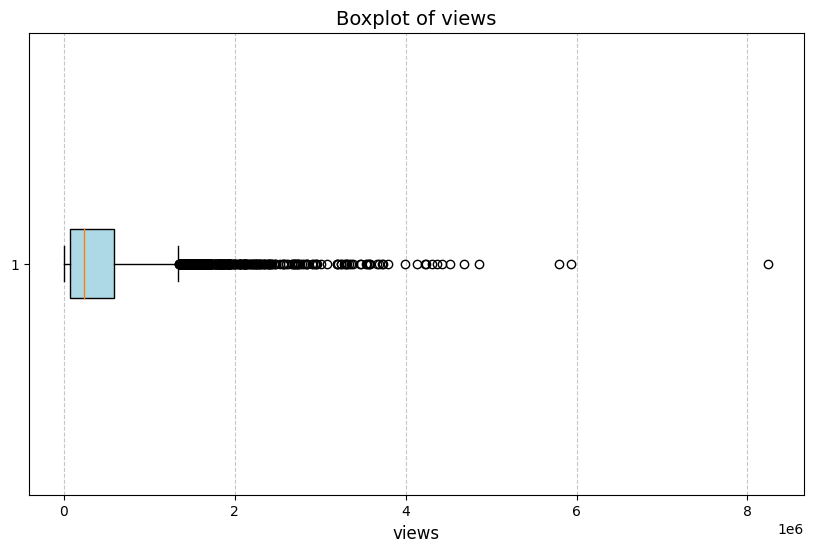

In [37]:
import matplotlib.pyplot as plt

def plot_boxplot(data, feature_name):
    plt.figure(figsize=(10, 6))
    plt.boxplot(data[feature_name], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title(f"Boxplot of {feature_name}", fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

plot_boxplot(df, 'views')

We can see that there are many outliers with views significantly higher than the rest of the data. A few extreme points even exceed 6 million views.

We will apply og transformation to make the distribution more normal-like, reducing the impact of outliers.

In [38]:
zero_views_count = (df['views'] == 0).sum()
print(f"Number of zero values in 'views': {zero_views_count}")

Number of zero values in 'views': 0


In [39]:
# no zero values in `View`
df['log_views'] = np.log1p(df['views']) 

In [40]:
# reminder base RMSE 0.6397883821576876

X_log_views = df.drop(columns=['views', 'likes_log'])

# Train and evaluate
model, rmse_log_views = train_and_evaluate(X_log_views, y)
print("RMSE with log_views:", rmse_log_views)

RMSE with log_views: 0.638694984214127


In [41]:
import numpy as np
import pandas as pd

# Calculate Q1, Q3, and IQR
Q1 = df['views'].quantile(0.25)
Q3 = df['views'].quantile(0.75)
IQR = Q3 - Q1

# Scale the data using IQR
df['scaled_views'] = (df['views'] - Q1) / IQR

# Optionally: Capping outliers based on the IQR method
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['capped_views'] = df['views'].clip(lower=lower_bound, upper=upper_bound)

In [42]:
X_capped_views = df.drop(columns=['views', 'log_views', 'likes_log'])

# Train and evaluate
model, rmse_capped_views = train_and_evaluate(X_capped_views, y)
print("RMSE with capped_views:", rmse_capped_views)

RMSE with capped_views: 0.6326911826832455


We see a better improvement in the RMSE value, after Scaling using Interquartile Range (IQR) method.
Hence, we will keep `capped_views` and We will apply the same process for the other features we got when implementing detect_outliers.

In [43]:
df.drop(columns=['views', 'log_views'], inplace=True) 

In [44]:
import pandas as pd
import numpy as np

# (excluding 'views' as it's already handled)
features_to_process = [
    'comment_count', 'days_to_trend', 'dislikes_log', 
    'dislikes_views_ratio', 'comments_views_ratio'
]

# Function to detect and cap outliers for a given feature
def cap_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[feature + '_capped'] = df[feature].clip(lower=lower_bound, upper=upper_bound)


for feature in features_to_process:
    cap_outliers(df, feature)

for feature in features_to_process:

    X_capped = df.drop(columns=[feature, 'likes_log']) 
    y = df['likes_log']  

    model, rmse_capped = train_and_evaluate(X_capped, y)
    print(f"RMSE with capped {feature}: {rmse_capped}")


RMSE with capped comment_count: 0.6434234157577465
RMSE with capped days_to_trend: 0.652658239180557
RMSE with capped dislikes_log: 0.646443030064748
RMSE with capped dislikes_views_ratio: 0.6468325037336841
RMSE with capped comments_views_ratio: 0.6466667477037924


In [45]:
# evaluate when all features capped togheter
X_capped_all = df.drop(columns=['likes_log'] + features_to_process)  
y = df['likes_log']  


model, rmse_capped_all = train_and_evaluate(X_capped_all, y)
print(f"RMSE with capped:{rmse_capped_all}")

RMSE with capped:0.6329647383109775


Since the RMSE with all capped features (0.1279) does not significantly improve over the individual capped features (especially the dislikes_log feature with 0.1203), we might not want to keep all features capped.

We keep only the capped dislikes_log feature that was significantly lower than the RMSE with the other capped features and even better than the RMSE with all capped features.

In [46]:
df.drop(columns=['comment_count_capped', 'days_to_trend_capped',
                 'dislikes_views_ratio_capped', 'comments_views_ratio_capped'], inplace=True)

df.drop(columns=['dislikes_log'], inplace=True)


### Hyperparameter Tuning

re-evaluating Part 1 model preformance

In [57]:
path = "./clean_data.csv"
df_part1 = pd.read_csv(path)

X = df_part1.drop(columns=["likes"])
y = df_part1["likes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_error,
)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"R2 score on train set: {r2_train:.2f}")
print(f"R2 score on test set: {r2_test:.2f}")


R2 score on train set: 1.00
R2 score on test set: 0.77


model performace using hyperparameter tuning

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

y = df['likes_log']
X = df.drop(columns=['likes_log']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200], 
    'max_depth': [3, 4, 5], 
    'subsample': [0.8, 0.9],  
    'colsample_bytree': [0.8, 0.9]
}

XGBRegressor(random_state=42, early_stopping_rounds=10)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20, cv=5, random_state=42)
random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Get the best hyperparameters
print(f"Best hyperparameters: {random_search.best_params_}")
best_model = random_search.best_estimator_

# Train the best model and evaluate on the test set
y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE on test set: {rmse_test}")

# Evaluate on the training set to check for overfitting
y_pred_train = best_model.predict(X_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
print(f"RMSE on train set: {rmse_train}")



Best hyperparameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
RMSE on test set: 0.6202101938012936
RMSE on train set: 0.5180777825749874


we specified `early_stopping_rounds=10` in the XGBRegressor model, for the model to evaluate performance on the validation set after each round, and stop early if there is no improvement. effectively limiting overfitting. Which we can see by the RMSE on the train set (0.5181) is much better than the test set (0.6202), (the model fits too well to the training data but struggles on unseen test data).

In [53]:
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred)
print(f"R² (train): {r2_train:.3f}")
print(f"R² (test): {r2_test:.3f}")

R² (train): 0.926
R² (test): 0.891


In [54]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.0f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.0f}")

residuals = y_test - y_pred
max_error = residuals.abs().max()
print(f"Max Error: {max_error:.0f}")

Mean Absolute Percentage Error (MAPE): 6.47%
Mean Absolute Error (MAE): 0
Root Mean Squared Error (RMSE): 1
Max Error: 4


We wont compare Metrics like RMSE, MAE, and MAPE becaue log-transformed data are not directly comparable to the original scale because they measure errors on a different scale.
But we can see improvement on R² score:  improved from 0.77 (test set) to 0.891 